In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf # pip install tensorflow-macos
import os
tf.random.set_seed(1)

## functions from binary classification notebook:

In [38]:
import random
import matplotlib.image as mpimg

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}") # show the shape of the image
  return img


def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()
  plt.show()


def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img


def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False)
  plt.show()

# Multi-class CNN's part 1: Becoming one with the data

In [3]:
print(os.getcwd())

/Users/NoahRipstein/PycharmProjects/Tensorflow tutorial att2


In [4]:
import zipfile

zip_path = "10_food_classes_all_data.zip"
if not os.path.isfile(zip_path):
    os.chdir("data")

zip_ref = zipfile.ZipFile(zip_path, "r")
zip_ref.extractall()
zip_ref.close()

In [5]:
# Walk through 10_food_classes directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_all_data"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 

In [6]:
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [7]:
# Get the class names for our multi-class dataset
import pathlib

data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


Image shape: (512, 382, 3)


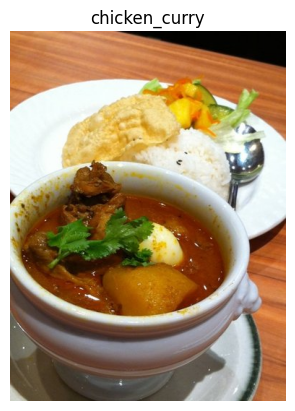

In [8]:
img = view_random_image(target_dir=train_dir,
                        target_class=random.choice(class_names)) # get a random class name

# Multi-class CNN's part 2: Preparing our data

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# rescale
train_datagen = ImageDataGenerator(1./255)
test_datagen = ImageDataGenerator(1./255)

# load data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="categorical",
                                               seed=1)

test_data = test_datagen.flow_from_directory(test_dir,
                                              batch_size=32,
                                              target_size=(224, 224),
                                              class_mode="categorical",
                                              seed=1)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


# Multi-class CNN's part 3: Building a multi-class CNN model

In [10]:
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(10, 3, activation="relu", input_shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation="softmax")
])

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

# Create our model (a clone of model_8, except to be multi-class)
model_1 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(10, activation='softmax') # changed to have 10 neurons (same as number of classes) and 'softmax' activation
])

model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),  # categorical rather than spasecategorical bc effectivley one hot encoded labels
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [11]:
history_1 = model_1.fit(train_data,
            epochs=5,
            steps_per_epoch=len(train_data),
            validation_data=test_data,
            validation_steps=int(0.5 * len(test_data))) # *0.5 so we only bother with 50% while testing to save time

Epoch 1/5


/Users/NoahRipstein/PycharmProjects/Tensorflow tutorial att2/venv/lib/python3.10/site-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
2023-05-04 23:57:41.559056: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


235/235 [==============================] - 92s 391ms/step - loss: 24.7799 - accuracy: 0.1140 - val_loss: 2.2943 - val_accuracy: 0.1298
Epoch 2/5
235/235 [==============================] - 99s 420ms/step - loss: 2.1130 - accuracy: 0.2243 - val_loss: 2.3266 - val_accuracy: 0.1562
Epoch 3/5
235/235 [==============================] - 121s 517ms/step - loss: 1.7631 - accuracy: 0.3820 - val_loss: 2.5696 - val_accuracy: 0.1611
Epoch 4/5
235/235 [==============================] - 101s 428ms/step - loss: 1.3520 - accuracy: 0.5420 - val_loss: 2.9662 - val_accuracy: 0.1402
Epoch 5/5
235/235 [==============================] - 100s 426ms/step - loss: 0.9745 - accuracy: 0.6855 - val_loss: 3.7288 - val_accuracy: 0.1522


that was SLOW on my mac

# Multi-class CNN's part 5: Evaluating our multi-class CNN model

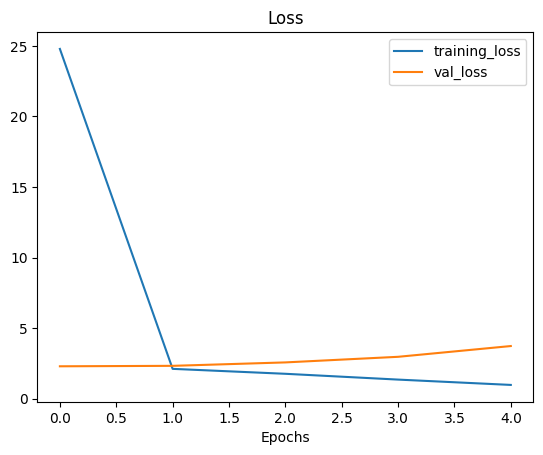

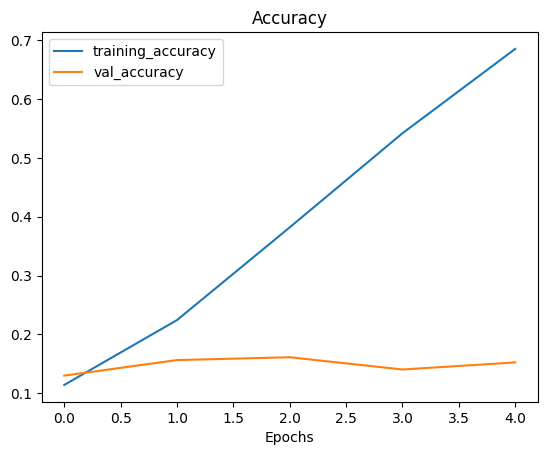

In [12]:
plot_loss_curves(history_1)

Not doing well on test data

# Multi-class CNN's part 6: Trying to fix overfitting by removing layers

In [13]:
# current model:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_5 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 110, 110, 10)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_7 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                  

In [14]:
# try by removing conv layers
model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(10, 3, input_shape=(224, 224, 3), activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation="softmax")
])

model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_2.summary()
# note it's similar number of params

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 10)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 10)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 29160)             0         
                                                                 
 dense_2 (Dense)             (None, 10)               

In [16]:
history_2 = model_2.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=int(0.5 * len(test_data)))

Epoch 1/5


/Users/NoahRipstein/PycharmProjects/Tensorflow tutorial att2/venv/lib/python3.10/site-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


235/235 [==============================] - 40s 171ms/step - loss: 13.2999 - accuracy: 0.1219 - val_loss: 2.2989 - val_accuracy: 0.1330
Epoch 2/5
235/235 [==============================] - 45s 192ms/step - loss: 2.1032 - accuracy: 0.2389 - val_loss: 2.3713 - val_accuracy: 0.1394
Epoch 3/5
235/235 [==============================] - 50s 213ms/step - loss: 1.7016 - accuracy: 0.4096 - val_loss: 2.6675 - val_accuracy: 0.1178
Epoch 4/5
235/235 [==============================] - 42s 177ms/step - loss: 1.2642 - accuracy: 0.5787 - val_loss: 3.2437 - val_accuracy: 0.1306
Epoch 5/5
235/235 [==============================] - 44s 188ms/step - loss: 0.9358 - accuracy: 0.7015 - val_loss: 3.8303 - val_accuracy: 0.1386


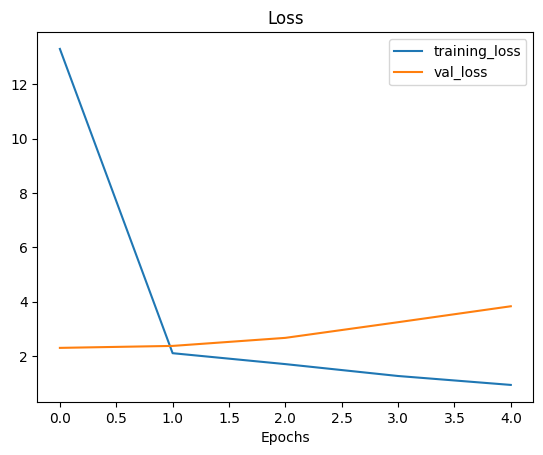

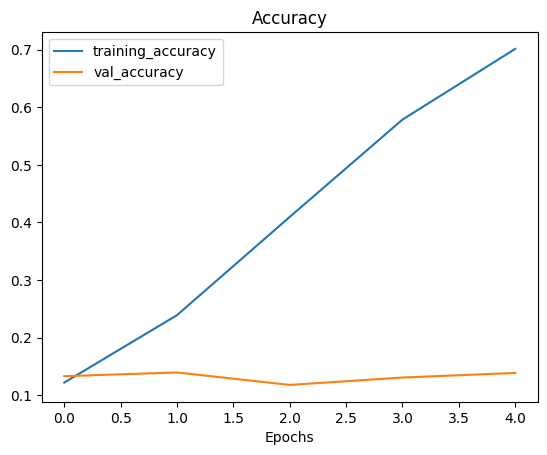

In [17]:
plot_loss_curves(history_2)

similar accuracy and loss curves. the number of parameters didn't really go down by removing Conv2D layers.

# Multi-class CNN's part 7: Trying to fix overfitting with data augmentation

In [24]:
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20,  # how much to rotate
                                             shear_range=0.2,  # how much to shear
                                             zoom_range=0.2,  # how much to zoom
                                             height_shift_range=0.3,  # how much to horizontal shift
                                             width_shift_range=0.2,  # how much to vertical shift
                                             horizontal_flip=True)

train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode="categorical")

Found 7500 images belonging to 10 classes.


In [25]:
# a model with the augmented training data
model_3 = tf.keras.models.clone_model(model_1) # gets same architecture as model 1

model_3.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [26]:
history_3 = model_3.fit(train_data_augmented,
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=test_data,
                        validation_steps=(0.5 * len(test_data)))

Epoch 1/5
235/235 [==============================] - ETA: 0s - loss: 2.2234 - accuracy: 0.1764

/Users/NoahRipstein/PycharmProjects/Tensorflow tutorial att2/venv/lib/python3.10/site-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


235/235 [==============================] - 130s 550ms/step - loss: 2.2234 - accuracy: 0.1764 - val_loss: 81.4059 - val_accuracy: 0.1539
Epoch 2/5
235/235 [==============================] - 124s 528ms/step - loss: 2.1308 - accuracy: 0.2369 - val_loss: 241.0090 - val_accuracy: 0.1813
Epoch 3/5
235/235 [==============================] - 127s 539ms/step - loss: 2.0636 - accuracy: 0.2844 - val_loss: 144.2392 - val_accuracy: 0.2758
Epoch 4/5
235/235 [==============================] - 119s 504ms/step - loss: 2.0078 - accuracy: 0.3005 - val_loss: 270.9955 - val_accuracy: 0.2625
Epoch 5/5
235/235 [==============================] - 147s 626ms/step - loss: 1.9589 - accuracy: 0.3227 - val_loss: 255.9693 - val_accuracy: 0.2484


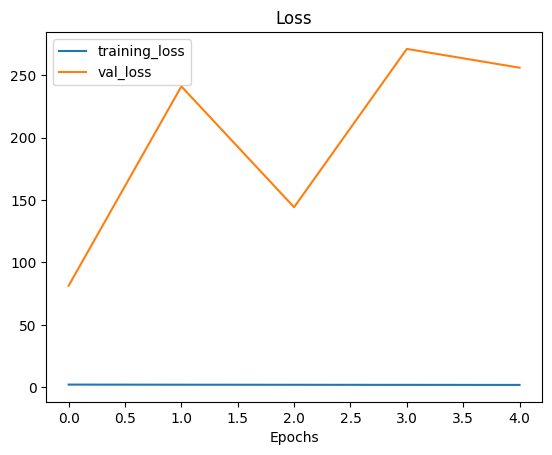

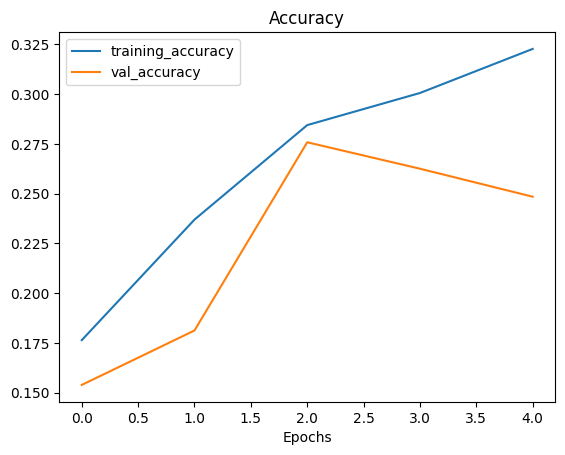

In [27]:
plot_loss_curves(history_3)

# Multi-class CNN's part 8: Things you could do to improve your CNN model
### things to try
- changing model architecture
- adjust learning rate
- change data augmentation parameters
- training for more epochs
- transfer learning

# Multi-class CNN's part 9: Making predictions with our model on custom images

1/1 [==============================] - 0s 11ms/step


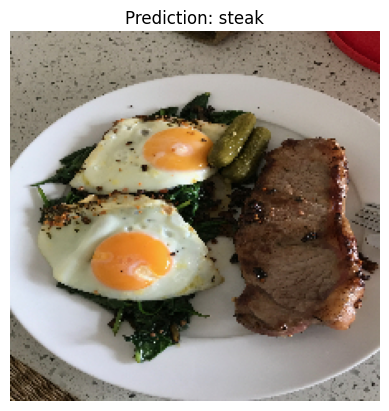

1/1 [==============================] - 0s 12ms/step


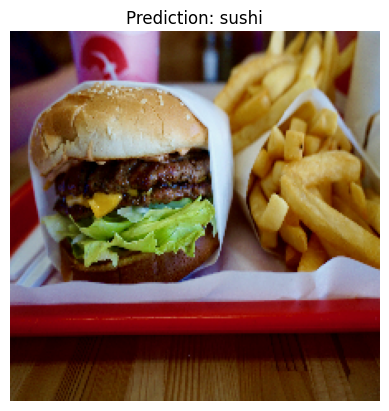

1/1 [==============================] - 0s 13ms/step


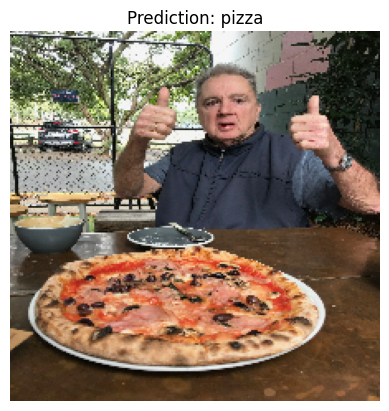

1/1 [==============================] - 0s 15ms/step


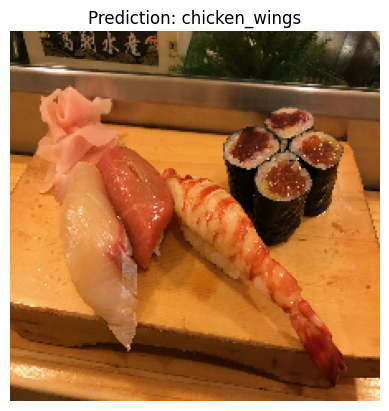

In [40]:
pred_and_plot(model=model_3,
              filename="steak_example.jpeg",
              class_names=class_names)
pred_and_plot(model=model_3,
              filename="03-hamburger.jpeg",
              class_names=class_names)
pred_and_plot(model=model_3,
              filename="03-pizza-dad.jpeg",
              class_names=class_names)
pred_and_plot(model=model_3,
              filename="03-sushi.jpeg",
              class_names=class_names)

well, that didn't go well at all. transfer learning is the answer!

# Saving and loading our trained CNN model

In [51]:
# save a model
os.chdir("/Users/NoahRipstein/PycharmProjects/Tensorflow tutorial att2")

model_3.save("multiclass_CNN_model_3")

/Users/NoahRipstein/PycharmProjects/Tensorflow tutorial att2
3
INFO:tensorflow:Assets written to: multiclass_CNN_model_3/assets


INFO:tensorflow:Assets written to: multiclass_CNN_model_3/assets


In [55]:
# Load in a model and evaluate it
loaded_model_3 = tf.keras.models.load_model("multiclass_CNN_model_3")
# loaded_model_3.evaluate(test_data) # NOT SURE WHY THIS LINE DOESNT WORK, LOOK INTO IT